In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math
import os

import tensorflow as tf
from im2txt import configuration
from im2txt import inference_wrapper
from im2txt.inference_utils import caption_generator
from im2txt.inference_utils import vocabulary
import matplotlib.pyplot as plt
from PIL import Image

import pandas as pd

D:\Anaconda3\lib\site-packages\ipykernel\parentpoller.py:116: UserWarning: Parent poll failed.  If the frontend dies,
                the kernel may be left running.  Please let us know
                about your system (bitness, Python, etc.) at
                ipython-dev@scipy.org
  ipython-dev@scipy.org""")


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
# 训练好的模型存放路径
checkpoint_path = "./model/model.ckpt-3000000"
# 词汇表
vocab_file = "./im2txt/data/word_counts.txt"
# 图片路径
input_files = os.path.join(os.path.dirname(os.getcwd()),"images/")
# 输出路径
output_files=os.path.join(os.path.dirname(os.getcwd()),"images_result.csv")

In [3]:
# 储存图片的内容
df = pd.DataFrame(columns=["Image_Path","Image_Content"])

#print(df)

In [4]:
# 载入训练好的模型
g = tf.Graph()
with g.as_default():
    model = inference_wrapper.InferenceWrapper()
    restore_fn = model.build_graph_from_config(configuration.ModelConfig(), checkpoint_path)

# 载入词表
vocab = vocabulary.Vocabulary(vocab_file)


INFO:tensorflow:Building model.
Instructions for updating:
Queue-based input pipelines have been replaced by `tf.data`. Use `tf.data.TFRecordDataset`.





Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use `tf.cast` instead.



Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



INFO:tensorflow:Initializing vocabulary from file: ./im2txt/data/word_counts.txt

INFO:tensorflow:Created vocabulary with 11520 words


INFO:tensorflow:Loading model from checkpoint: ./model/model.ckpt-3000000
INFO:tensorflow:Restoring parameters from ./model/model.ckpt-3000000
INFO:tensorflow:Successfully loaded checkpoint: model.ckpt-3000000
E:\大学相关\大学相关（大四春）\major\workspace\images/1.jpg
Instructions for updating:
Use tf.gfile.GFile.
  0) a dog laying on the grass with a soccer ball . (p=0.000563)
  1) a dog laying on the grass with a soccer ball in its mouth . (p=0.000241)
  2) a dog laying on the ground with a soccer ball in its mouth . (p=0.000103)


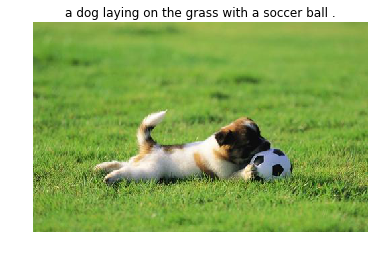

1.jpg Success!
E:\大学相关\大学相关（大四春）\major\workspace\images/2.jpg
  0) a white and white cat is sitting in the grass . (p=0.000310)
  1) a white and white cat is sitting in a field (p=0.000297)
  2) a white and white cat is sitting in the grass (p=0.000211)


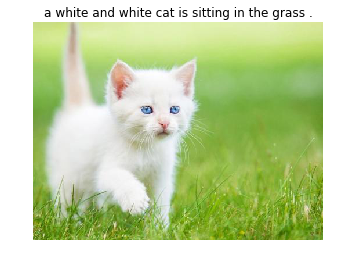

2.jpg Success!
E:\大学相关\大学相关（大四春）\major\workspace\images/3.jpg
  0) a woman standing on a beach holding a surfboard . (p=0.001779)
  1) a person standing on a beach holding a surf board (p=0.001569)
  2) a man standing on a beach holding a surfboard . (p=0.001504)


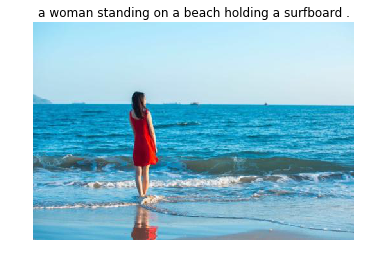

3.jpg Success!
Process Success!


In [5]:
#进行处理
with tf.Session(graph=g) as sess:
    # 载入训练好的模型
    restore_fn(sess)
    generator = caption_generator.CaptionGenerator(model, vocab)
         
    # 循环文件夹
    for root,dirs,files in os.walk(input_files):
        for file in files:
            # 打印图片路径及名称
            image_path = os.path.join(root,file)
            print(image_path)
            # 载入图片
            image = tf.gfile.FastGFile(os.path.join(root,file), 'rb').read()   
            # 获得图片描述
            captions = generator.beam_search(sess, image)
            # 打印多个标题
            for i, caption in enumerate(captions):
                sentence = [vocab.id_to_word(w) for w in caption.sentence[1:-1]]
                sentence = " ".join(sentence)
                if i == 0:
                    title = sentence
                print("  %d) %s (p=%f)" % (i, sentence, math.exp(caption.logprob)))

            # 显示图片
            img=Image.open(image_path)
            plt.imshow(img)
            plt.title(title)
            plt.axis('off')
            plt.show()
            
            #将图片路径以及内容保存
            tmp_df = pd.DataFrame(data=[[image_path,title]], columns=["Image_Path","Image_Content"])
            df = df.append(tmp_df)#这里一定要再赋值一次
            
            print(file+" Success!")

print("Process Success!")

In [6]:
#将结果储存到csv中
df.reset_index(drop=True, inplace=True)
df.to_csv(output_files)